In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pyswarms as ps

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Solver

This code initializes generator state variables and network terminal variables

In [2]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb])
    
    return x, V, c

This code solves non-liear constraint optimization

In [3]:
def constraint_objective(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    res = np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    return np.linalg.norm(res, 2) ** 2

def constraint_objective2(theta, x, xx, c, S):
    return constraint_objective(x, xx, c, S, theta)

def constraint_jacobian(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [ra, -x1d, id, -iq],
        [xq, ra, iq, id],
        [(x1d * xq + ra ** 2), 0, vd, vq],
        [0, (x1d * xq + ra ** 2), vq, -vd]
    ])
    
    return m @ dif

def constraint_jacobian2(theta, x, xx, c, S):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [0, 0, 0, 0],
        [2 * ra * id + vd, 2 * ra * iq - e1q + vq, 0, 0],
        [xq * id, xq * iq - vd, 0, 0],
        [0, 0, 0, 0],
        [x1d * id - e1q + vq, x1d * iq, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    
    return m @ dif

def constraint_solve(x, V, c, S, theta, threshold=1e-16):
    if constraint_objective(V, x, c, S, theta) < threshold:
        return V
    else:
        return minimize(constraint_objective,
                        x0=V,
                        args=(x, c, S, theta),
                        method='L-BFGS-B',
                        jac=constraint_jacobian, bounds=[(0., None)] * 4).x

This code defines transition from one time step to another

In [4]:
def transition(x, V, c, S, theta, tau=0.1, tol=1e-16):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    
    Vnew = constraint_solve(x, V, c, S, theta, threshold=tol)
    vd, vq, id, iq = Vnew
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    xnew = x + tau * np.array([
        wb * (w - ws),
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, Vnew

This code defines interface to solver in one function call

In [5]:
def solve(df, tau=0.1, tol=1e-16):
    theta0 = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta0)
    xs = [x0]
    Vs = [V0]
    for t in range(1, len(df)):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, df[['p', 'q']].values[t], theta0, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs

def solve_for_theta(injection, theta, tau=0.1, tol=1e-16):
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta)
    xs = [x0]
    Vs = [V0]
    for t in range(1, injection.shape[0]):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, injection[t], theta, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs, c

## Learner

This code defines the ODE part and its derivative

In [6]:
def learning_f(x, v, c, theta):
    """
    Return f-function value
    """
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vd, vq, id, iq = v
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    return np.array([
        wb * (w - ws),
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])

def learning_grad_f(x, V, c, theta):
    """
    Retrun f-function gradient w.r.t. theta
    """
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vd, vq, id, iq = V
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    g1 = (pm - (vq + ra * iq) * iq - (vd + ra * id) * id + KD) / (2 * H)
    g2 = - ws * (iq ** 2 + id ** 2) / (2 * H)
    g3 = - ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H ** 2)
    g4 = ws * (w / ws - 1) / (2 * H)
    g5 = Kw * g1
    g6 = Kw * g2
    g7 = Kw * g3
    g8 = Kw * g4
    g9 = ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H)
    g10 = - v2 / (Tw ** 2)
    g11 = g5 * Tpss1 / Tpss2
    g12 = g6 * Tpss1 / Tpss2
    g13 = g7 * Tpss1 / Tpss2
    g14 = g8 * Tpss1 / Tpss2
    g15 = g9 * Tpss1 / Tpss2
    g16 = g10 * Tpss1 / Tpss2
    g17 = Kw * g9 / Tpss2
    g18 = - Kw * g9 * Tpss1 / (Tpss2 ** 2)
    g19 = - (vt - vm) / (Tr ** 2)
    g20 = - K0 * (vref + vs - vm) / (Tavr2 ** 2)
    g21 = - (K0 * (vref + vs - vm) - vr) / (Tavr2 ** 2) + 2 * K0 * Tavr1 * (vref + vs - vm) / (Tavr2 ** 3)
    g22 = (1 - Tavr1 / Tavr2) * (vref + vs - vm) / Tavr2
    g23 = K0 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Tavr2 * Te)
    g24 = - K0 * Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2 ** 2)
    g25 = - ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / (Te ** 2)
    g26 = Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2)
    g27 = id / T1d0
    g28 = - g27
    g29 = - (- e1q - (xd - x1d) * id + vf) / T1d0 ** 2
    
    jac = np.array([
        [-wb, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [g1, g2, 0, 0, 0, g3, g4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [g5, g6, 0, 0, 0, g7, g8, 0, g9, g10, 0, 0, 0, 0, 0, 0, 0],
        [g11, g12, 0, 0, 0, g13, g14, 0, g15, g16, g17, g18, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g19, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g20, g21, 0, g22],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g23, g24, g25, g26],
        [0, 0, g27, g28, 0, 0, 0, g29, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
    
    return jac

This code defines the gradient descent in ODEs part

In [7]:
def learning_objective(xs, vs, c, theta, tau, alpha, p=1000):
    """
    Objective to minimize. Sum over time of 2nd norm of error in ODEs.
    """
    dxs = [(xp - xm) / tau for xp, xm in zip(xs[1:], xs[:-1])]
    
    obj = np.mean([np.linalg.norm(learning_f(x, v, c, theta) - dx, ord=2) ** 2 \
                   for x, v, dx in zip(xs[:-1:p], vs[:-1:p], dxs[::p])], axis=0)
        
    return obj + alpha * np.linalg.norm(theta, ord=2) ** 2 / 2

def learning_jacobian_once(x, V, dx, c, theta):
    """
    Objective Jacobian. One timestep.
    """
    jac = learning_grad_f(x, V, c, theta)
    F = learning_f(x, V, c, theta) - dx
    
    return (F @ jac).flatten()
    
def learning_jacobian(xs, vs, c, theta, tau, alpha, p=1000):
    """
    Objective Jacobian. Decomposes in time.
    """
    dxs = [(xp - xm) / tau for xp, xm in zip(xs[1:], xs[:-1])]
    jac = np.mean([2 * learning_jacobian_once(x, v, dx, c, theta) \
                   for x, v, dx in zip(xs[:-1:p], vs[:-1:p], dxs[::p])], axis=0)
        
    return jac + alpha * theta

This code defines the gradient descent in ODEs part with augmentation of algebraic part

In [8]:
def learning_objective_augmented(xs, vs, ss, c, theta, tau, lbd, alpha, p=1000):
    """
    Objective to minimize with augmentation.
    """
    obj = learning_objective(xs, vs, c, theta, tau, alpha)
    aug = np.mean([constraint_objective(v, x, c, s, theta) \
                   for x, v, s in zip(xs[:-1:p], vs[:-1:p], ss[:-1:p])], axis=0)
    
    return obj + lbd * aug

def learning_jacobian_augmented(xs, vs, ss, c, theta, lbd, tau, alpha):
    """
    Objective Jacobian with augmentation.
    """
    jac = learning_jacobian(xs, vs, c, theta, tau, alpha)
    aug = np.mean([constraint_jacobian2(theta, v, x, c, s) \
                   for x, v, s in zip(xs[:-1:p], vs[:-1:p], ss[:-1:p])], axis=0)
    
    return jac + lbd * aug

This code solves initial parameter guess optimization

In [9]:
def learning_theta_objective(theta):
    x, v, c = get_initial_values(P0=1997.9999999936396,
                                 Q0=967.9249699065775,
                                 V0=1.0,
                                 angle0=0.494677176989154,
                                 theta0=theta)
    s = np.array([19.979999999936396, 9.679249699065775])
    
    f = learning_f(x, v, c, theta)
    
    return constraint_objective2(theta, v, x, c, s) + np.linalg.norm(f, ord=2) ** 2

def learning_theta_guess(theta, threshold):
    if learning_theta_objective(theta) < threshold:
        return theta
    else:
        return minimize(learning_theta_objective,
                        x0=theta, bounds=[(0., None)] * 17).x

This code solves constraint (algebraic part) optimization

In [10]:
def learning_constraint_objective(theta, xs, vs, ss, c, theta0, lbd, mu, p=1000):
    """
    Constraint to project onto.
    """
    diff = np.linalg.norm(theta - theta0, ord=2) ** 2 / 2
    g_constraint = np.mean([constraint_objective2(theta, v, x, c, s) \
                            for x, v, s in zip(xs[:-1:p], vs[:-1:p], ss[:-1:p])], axis=0)
    f_constraint = np.linalg.norm(learning_f(xs[0], vs[0], c, theta), ord=2) ** 2 / 2
    return diff + lbd * g_constraint + mu * f_constraint
    
def learning_constraint_jacobian(theta, xs, vs, ss, c, theta0, lbd, mu, p=1000):
    """
    Constraint jacobian.
    """
    diff = theta - theta0
    g_constraint = np.mean([constraint_jacobian2(theta, v, x, c, s) \
                            for x, v, s in zip(xs[:-1:p], vs[:-1:p], ss[:-1:p])], axis=0)
    f_constraint = 2 * (learning_f(xs[0], vs[0], c, theta) @ learning_grad_f(xs[0], vs[0], c, theta)).flatten()
    return diff + lbd * g_constraint + mu * f_constraint

def learning_constraint_project(xs, vs, ss, c, theta, lbd, mu, threshold):
    if learning_constraint_objective(theta, xs, vs, ss, c, theta, lbd, mu) < threshold:
        return theta
    else:
        return minimize(learning_constraint_objective,
                        x0=theta,
                        args=(xs, vs, ss, c, theta, lbd, mu),
                        method='L-BFGS-B',
                        jac=learning_constraint_jacobian, bounds=[(0., None)] * 17).x

This code defines an interface for learner in one function call

In [11]:
def learning_step(theta, step, jac, projector):
    """
    Performs one gradient update and projection onto feasible region if necessary.
    """
    return projector(theta - step * jac)

def learning_scale(theta):
    return theta * np.array([10, 0.01, 1, 10, 10, 10, 1, 10, 100, 100, 0.1, 0.1, 0.1, 10, 10, 0.001, 1000])

def learning_scale_inv(theta):
    return theta / np.array([10, 0.01, 1, 10, 10, 10, 1, 10, 100, 100, 0.1, 0.1, 0.1, 10, 10, 0.001, 1000])

def learning_load(fname):
    df = pd.read_csv(fname).drop_duplicates('t').drop(['t'], axis=1)
    df.phi = df.phi * np.pi / 180
    return df[['p', 'q']].values, df[['v', 'phi']].values
    
def learning(injection, reference=None, method='psgd',
             stepsize=None, eta=1., steps=1e2,
             eps=1e-3, tau=1e-4, tol=1e-16,
             lbd=1e3, alpha=1.0,
             nu=1e3, mu=1e3):
    """
    Performs optimization via projected gradient descent or augmentated Jacobain.
    """
    assert method in ['psgd', 'augmented'], 'Method not recognized'
    Theta = learning_scale_inv(learning_theta_guess(learning_scale(np.abs(np.random.randn(17) / 10)), tol))
    Xs, Vs, C = solve_for_theta(injection, learning_scale(Theta), tau, tol)
    step_n = 0
    
    if method == 'augmented':
        lo = lambda xs, vs, ss, c, theta: learning_objective_augmented(xs, vs, ss, c, learning_scale(theta),
                                                                       tau, lbd, alpha)
        lj = lambda xs, vs, ss, c, theta: learning_jacobian_augmented(xs, vs, ss, c, learning_scale(theta),
                                                                      lbd, tau, alpha)
        lc = lambda xs, vs, ss, c, theta: theta
    else:
        lo = lambda xs, vs, ss, c, theta: learning_objective(xs, vs, c, learning_scale(theta), tau, alpha)
        lj = lambda xs, vs, ss, c, theta: learning_jacobian(xs, vs, c, learning_scale(theta), tau, alpha)
        lc = lambda xs, vs, ss, c, theta: learning_scale_inv(learning_constraint_project(xs, vs, ss, c,
                                                                                         learning_scale(theta),
                                                                                         nu, mu, tol))
        
    while step_n < steps and lo(Xs, Vs, injection, C, Theta) > eps:
        step = eta * (stepsize(step_n) if stepsize is not None else 1.)
        jac = lj(Xs, Vs, injection, C, Theta)
        if np.linalg.norm(jac, ord=2) > 1.:
            jac = jac / np.linalg.norm(jac, ord=2)
        proj = lambda theta: lc(Xs, Vs, injection, C, theta)
        Theta = learning_step(Theta, step, jac, proj)
        Xs, Vs, C = solve_for_theta(injection, learning_scale(Theta), tau, tol)
        step_n += 1
        if reference is not None:
            pred = np.array([np.sqrt(xx[0] ** 2 + xx[1] ** 2) for xx in Vs])
            print('Iteration %4d' % step_n,  'objective val %.3e' % lo(Xs, Vs, injection, C, Theta),
                  'solution NRMSE %.3e' % (np.linalg.norm(reference-pred)/np.linalg.norm(reference)))
            if step_n % 10 == 0:
                plt.plot(pred, label='predicted')
                plt.plot(reference, label='true')
                plt.show()
    return Theta

In [12]:
class Learner():
    def __init__(self, injections, folder, theta_true, stepsize=None, eta=1., steps=1e2,
                 eps=1e-3, tau=1e-4, tol=1e-16, lbd=1e3, alpha=1.0, nu=1e3, mu=1e3):
        self.injections = [os.path.join(folder, fname) for fname in injections]
        self.theta_true = theta_true
        self.stepsize = stepsize
        self.steps = steps
        self.eta = eta
        self.eps = eps
        self.tau = tau
        self.tol = tol
        self.lbd = lbd
        self.alpha = alpha
        self.nu = nu
        self.mu = mu
        
        self.theta = None
        
        self.lo = lambda xs, vs, ss, c, y: learning_objective(xs, vs, c, self.inverse_transform(y),
                                                              self.tau, self.alpha)
        self.lj = lambda xs, vs, ss, c, y: learning_jacobian(xs, vs, c, self.inverse_transform(y),
                                                             self.tau, self.alpha)
        self.lc = lambda xs, vs, ss, c, y: self.transform(learning_constraint_project(xs, vs, ss, c,
                                                                                      self.inverse_transform(y),
                                                                                      self.nu, self.mu, self.tol))

    def transform(self, x):
        return x / np.array([10., 0.01, 1., 10., 10., 10., 1., 10., 10., 10., 0.1, 0.1, 0.1, 1., 1., 0.001, 1000])
    
    def inverse_transform(self, x):
        return x * np.array([10., 0.01, 1., 10., 10., 10., 1., 10., 10., 10., 0.1, 0.1, 0.1, 1., 1., 0.001, 1000])
        
    def step(self, injection, i, Xs, Vs, C, lobj):
        step = self.eta * (self.stepsize(i) if self.stepsize is not None else 1.)
        jac = self.lj(Xs, Vs, injection, C, self.theta)
        jac = np.clip(jac, -1e3, 1e3)
        proj = lambda y: self.lc(Xs, Vs, injection, C, y)
        self.theta = learning_step(self.theta, step, jac, proj)
        Xs, Vs, C = solve_for_theta(injection, self.inverse_transform(self.theta), self.tau, self.tol)
        lobj = self.lo(Xs, Vs, injection, C, self.theta)
        return Xs, Vs, C, lobj
        
    def fit(self, theta0=None):
        if theta0 is None:
            self.theta = learning_theta_guess(np.abs(np.random.randn(17) * 10), self.tol)
            self.theta = self.transform(self.theta)
        else:
            self.theta = self.transform(theta0)
        injection, reference = learning_load(np.random.choice(self.injections))
        Xs, Vs, C = solve_for_theta(injection, self.inverse_transform(self.theta), self.tau, self.tol)
        lobj = self.lo(Xs, Vs, injection, C, self.theta)
        for i in range(self.steps):
            Xs, Vs, C, lobj = self.step(injection, i, Xs, Vs, C, lobj)
            if i % 50 == 0:
                VRs = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
                VIs = np.array([- vv[1] * np.sin(xx[0]) + vv[0] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
                pred = np.array([[np.sqrt(vr ** 2 + vi ** 2) for vr, vi in zip(VRs, VIs)],
                                 [np.arctan2(vi, vr) for vr, vi in zip(VRs, VIs)]]).T
                plt.clf()
                fig, ax = plt.subplots(1, 2, figsize=(20, 10))
                ax[0].plot(pred[:, 0], label='predicted')
                ax[0].plot(reference[:, 0], label='true')
                ax[0].legend()
                ax[0].set_title('V')
                ax[1].plot(pred[:, 1], label='predicted')
                ax[1].plot(reference[:, 1], label='true')
                ax[1].legend()
                ax[1].set_title('Phi')
                fig.savefig('saved_fig/epoch-%.4d.png' % i)
                plt.close()
                nrmse = np.sqrt(np.mean(np.linalg.norm(reference-pred, ord=2, axis=1)) ** 2)
                nrmse /= np.sqrt(np.mean(np.linalg.norm(reference, ord=2, axis=1) ** 2))
                dist = np.linalg.norm(self.inverse_transform(self.theta)-theta_true, ord=2)
                print('Iteration %4d' % i,  'objective val %.3e' % lobj,
                      'solution NRMSE %.3e' % nrmse,
                      'l2 distance to solution %.3e' % dist)
            injection, reference = learning_load(np.random.choice(self.injections))

## Testing

In [12]:
df = pd.read_csv('./exportedVariables.csv')

In [13]:
df.head()

,time,machine3.gen3.P,machine3.gen3.Q,machine3.gen3.v,machine3.gen3.anglev
0,0.0000,19.98,9.67925,1.0,28.3429
1,0.0001,19.98,9.67925,1.0,28.3429
2,0.0002,19.98,9.67925,1.0,28.3429
3,0.0003,19.98,9.67925,1.0,28.3429
4,0.0004,19.98,9.67925,1.0,28.3429


In [14]:
df = df.drop_duplicates('time')

In [15]:
df = df.drop(['time'], axis=1)

In [16]:
df.columns = ['p', 'q', 'v', 'phi']

In [17]:
df.phi = df.phi * np.pi / 180

### Testing learner

In [ ]:
old_settings = np.seterr(all='raise')

In [ ]:
theta_pred = learning(injection=df[['p', 'q']].values,
                      reference=df['v'].values,
                      stepsize=lambda k: max(1e-5, 1 / (1 + k % 50)), steps=1000,
                      alpha=0, eps=1e-8, nu=1e3, mu=1e3)
print(learning_scale(theta_pred))

Iteration    1 objective val 2.012e+09 solution NRMSE 1.460e-01
Iteration    2 objective val 1.125e+09 solution NRMSE 1.708e-01
Iteration    3 objective val 6.940e+08 solution NRMSE 1.808e-01
Iteration    4 objective val 4.919e+08 solution NRMSE 1.876e-01


In [ ]:
x, v, c = solve_for_theta(df[['p', 'q']].values, learning_scale(theta_pred), tau=0.0001)

In [ ]:
Vs = [np.sqrt(xx[0] ** 2 + xx[1] ** 2) for xx in v]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Vs, label='predicted')
plt.plot(df.v.values, label='true')
# plt.plot(np.abs(df.v.values - Vs))
plt.legend()

In [ ]:
np.seterr(**old_settings)

In [ ]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])

## Learner

In [22]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(20, 17, options)

In [23]:
def opt_fn(x):
    inj, _ = learning_load('data_simple/std_params/R_e1/data_10.csv')
    theta = x * np.array([10., 0.01, 1., 10., 10., 10., 1., 10., 10., 10., 0.1, 0.1, 0.1, 1., 1., 0.001, 1000])
    Xs, Vs, C = solve_for_theta(inj, theta, tau=1e-4)
    l_obj = learning_objective(Xs, Vs, C, x, 1e-4, 0)
    g_constraint = np.mean([constraint_objective2(x, v, xx, C, s) \
                            for xx, v, s in zip(Xs[::1000], Vs[::1000], inj[::1000])], axis=0)
    f_constraint = np.linalg.norm(learning_f(Xs[0], Vs[0], C, x), ord=2) ** 2 / 2
    return l_obj + 1e3 * g_constraint + 1e3 * f_constraint

In [ ]:
best_cost, best_pos = optimizer.optimize(lambda x: np.apply_along_axis(opt_fn, 1, x), 100, fast=True)

2019-04-18 17:43:24,941 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/100

pyswarms.single.global_best:   0%|          |0/100, best_cost=9.92e+06

pyswarms.single.global_best:   1%|          |1/100, best_cost=9.92e+06

pyswarms.single.global_best:   1%|          |1/100, best_cost=9.92e+06

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=9.92e+06

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=9.92e+06

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=9.92e+06

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=9.92e+06

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=9.92e+06

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=9.92e+06

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=9.92e+06

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=9.92e+06

pyswarms.single.global_best:  

In [26]:
lrn = Learner(injections=[xx for xx in os.listdir('data_simple/std_params/R_e1') if xx != '.DS_Store'],
              folder='data_simple/std_params/R_e1', theta_true=theta_true,
              stepsize=lambda k: max(1e-5, 1 / (1 + k % 100)), eta=1e-3, steps=10000,
              alpha=0, eps=1e-9, nu=1e3, mu=1e3)

<IPython.core.display.Javascript object>


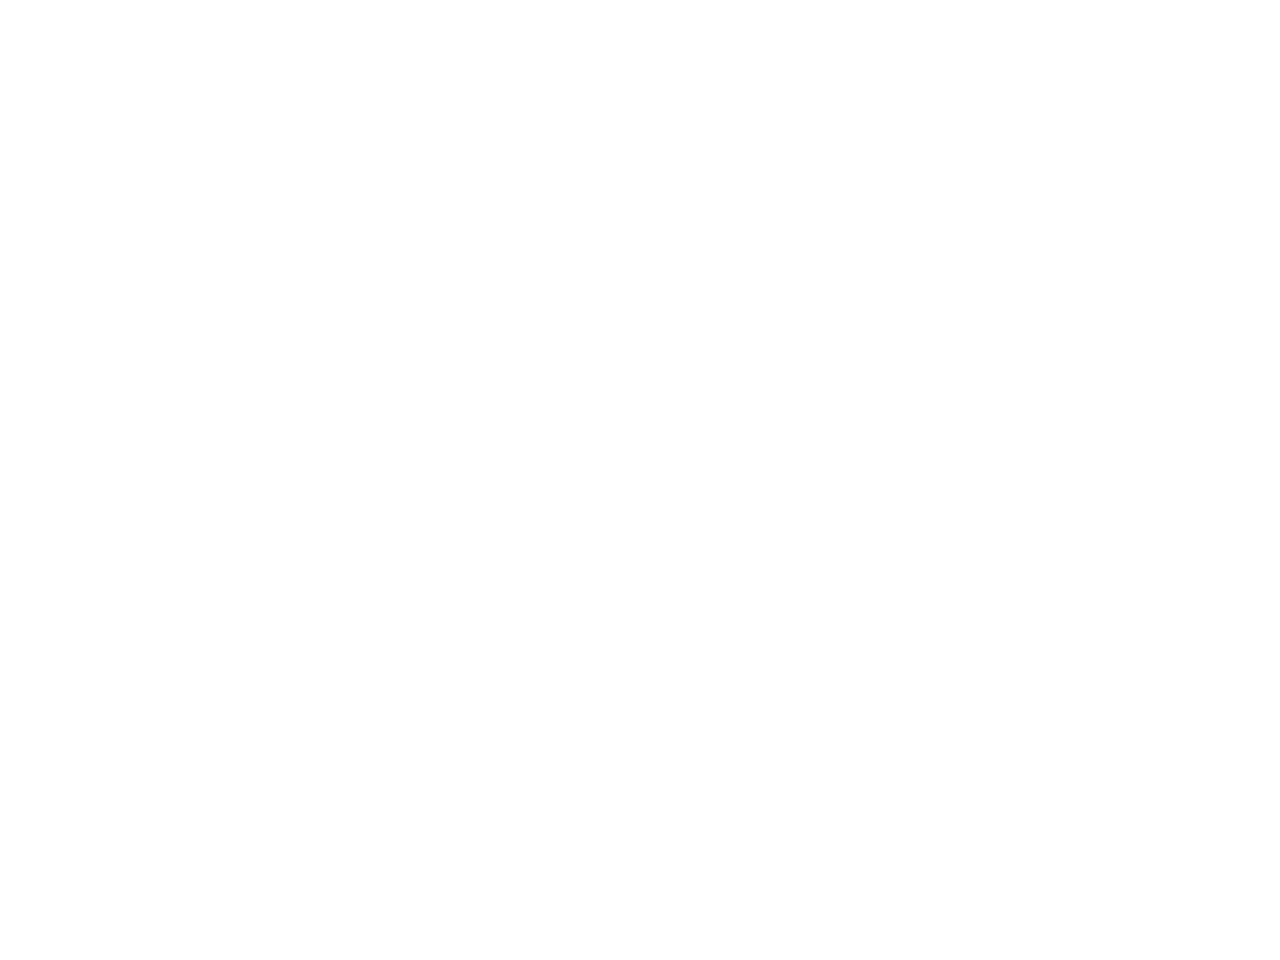

<IPython.core.display.Javascript object>


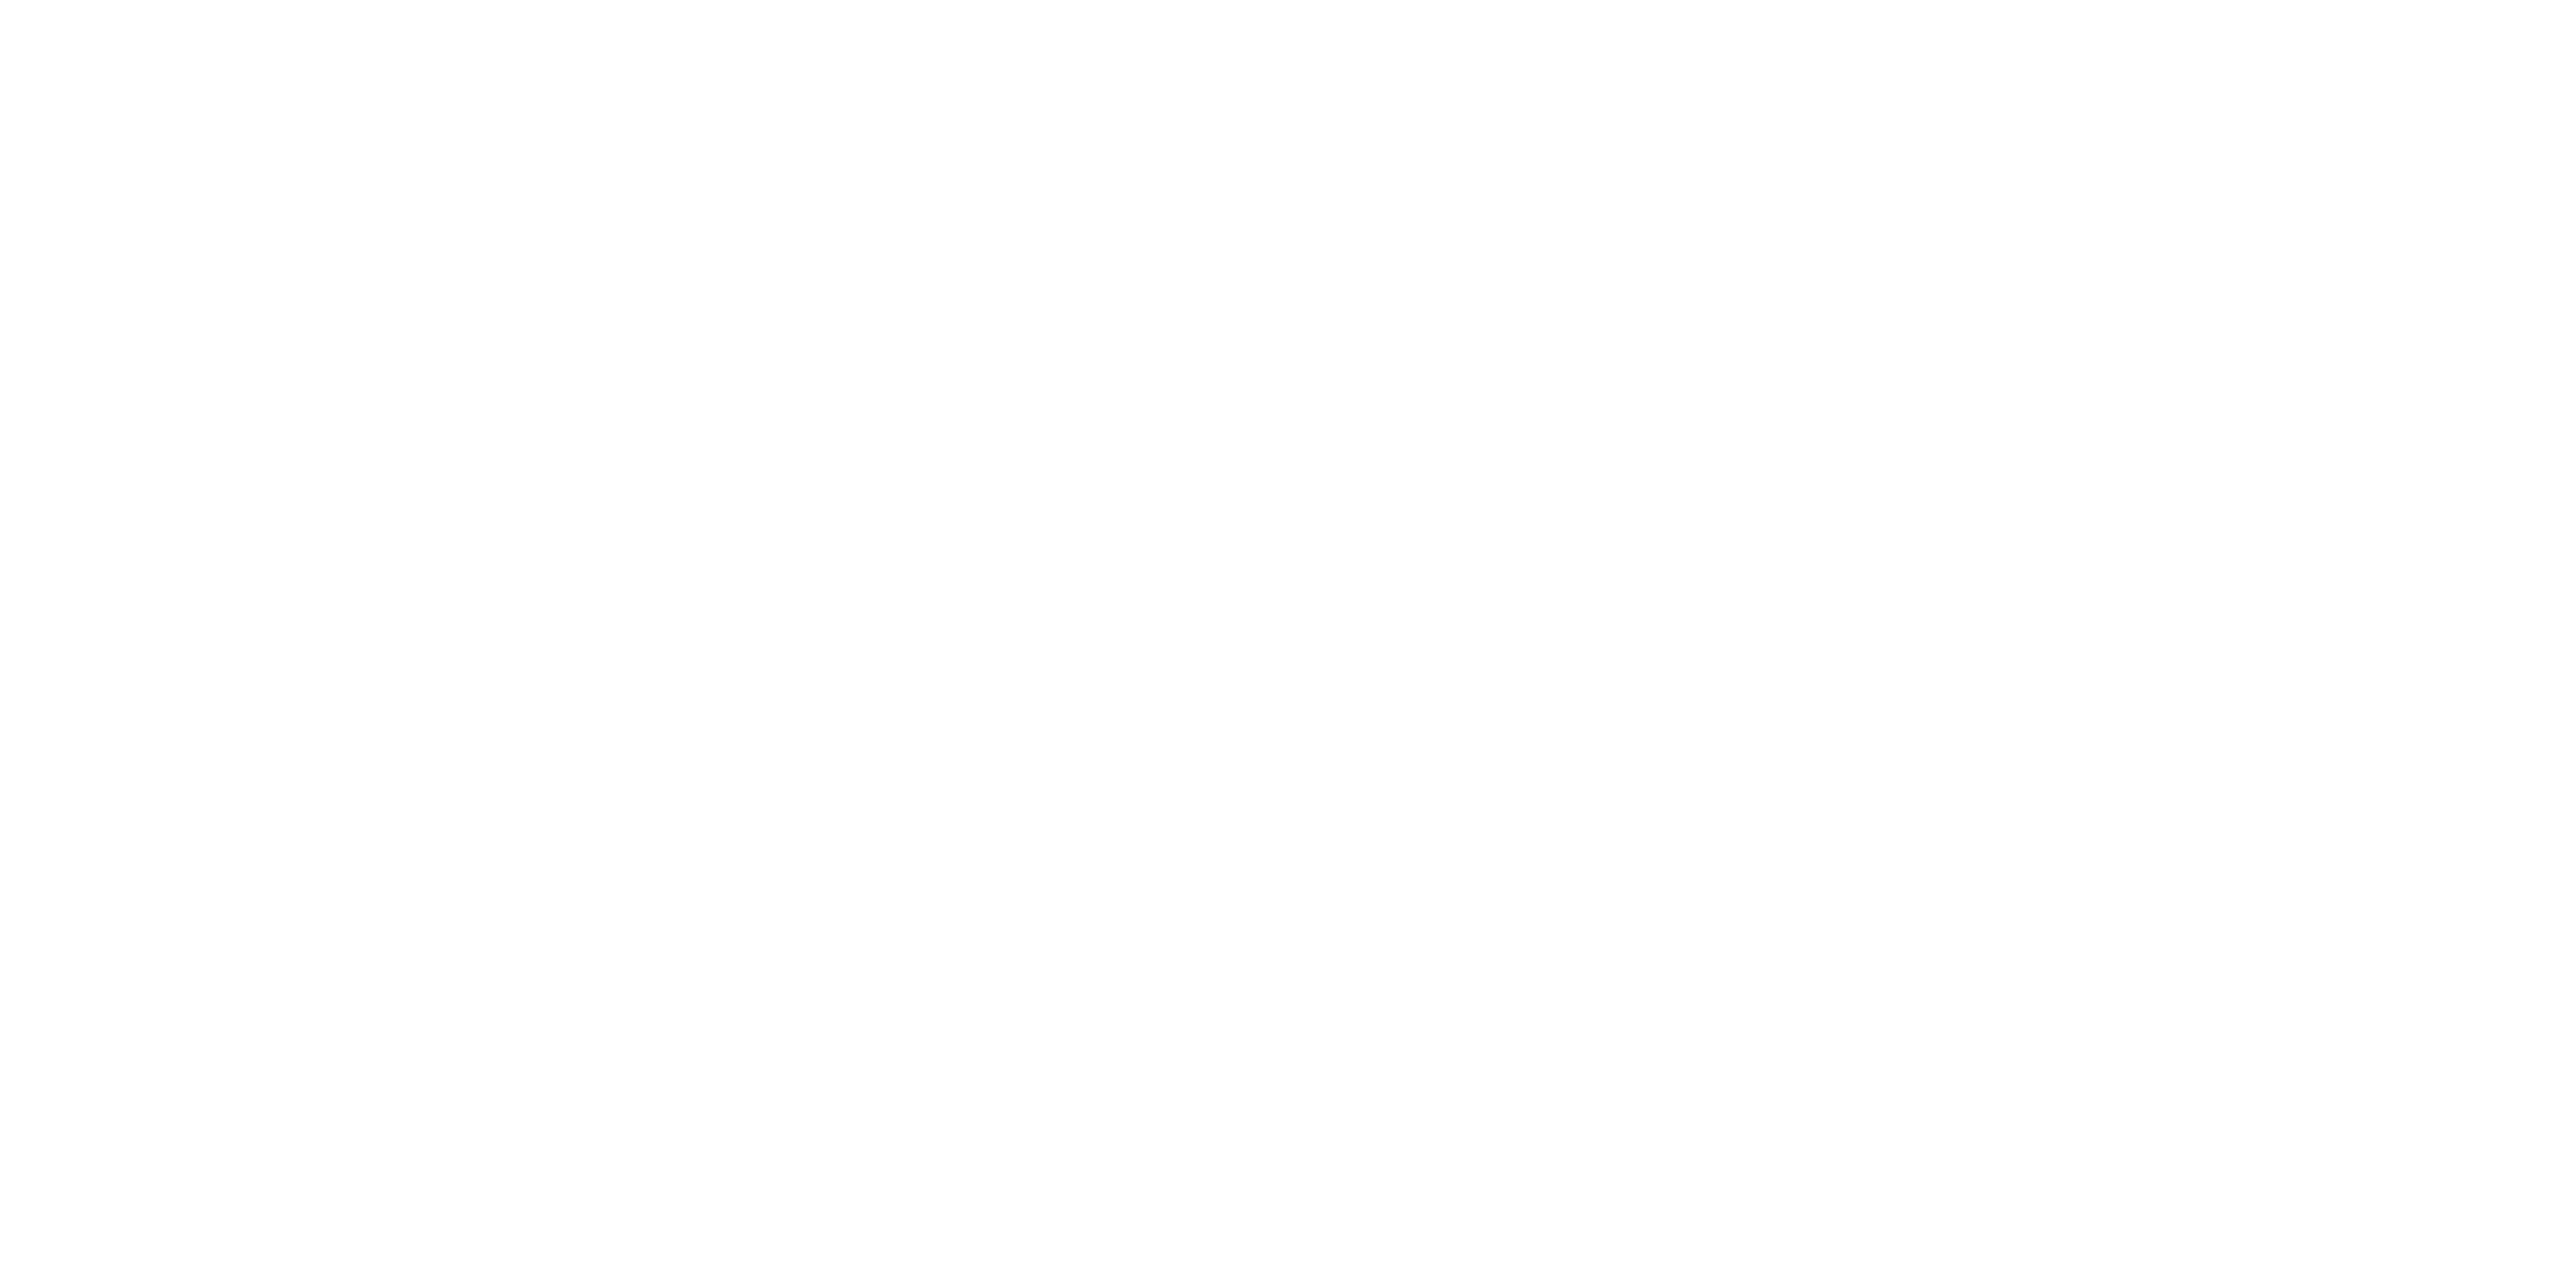

Iteration    0 objective val 6.822e+07 solution NRMSE 1.689e+00 l2 distance to solution 2.744e+02


<IPython.core.display.Javascript object>


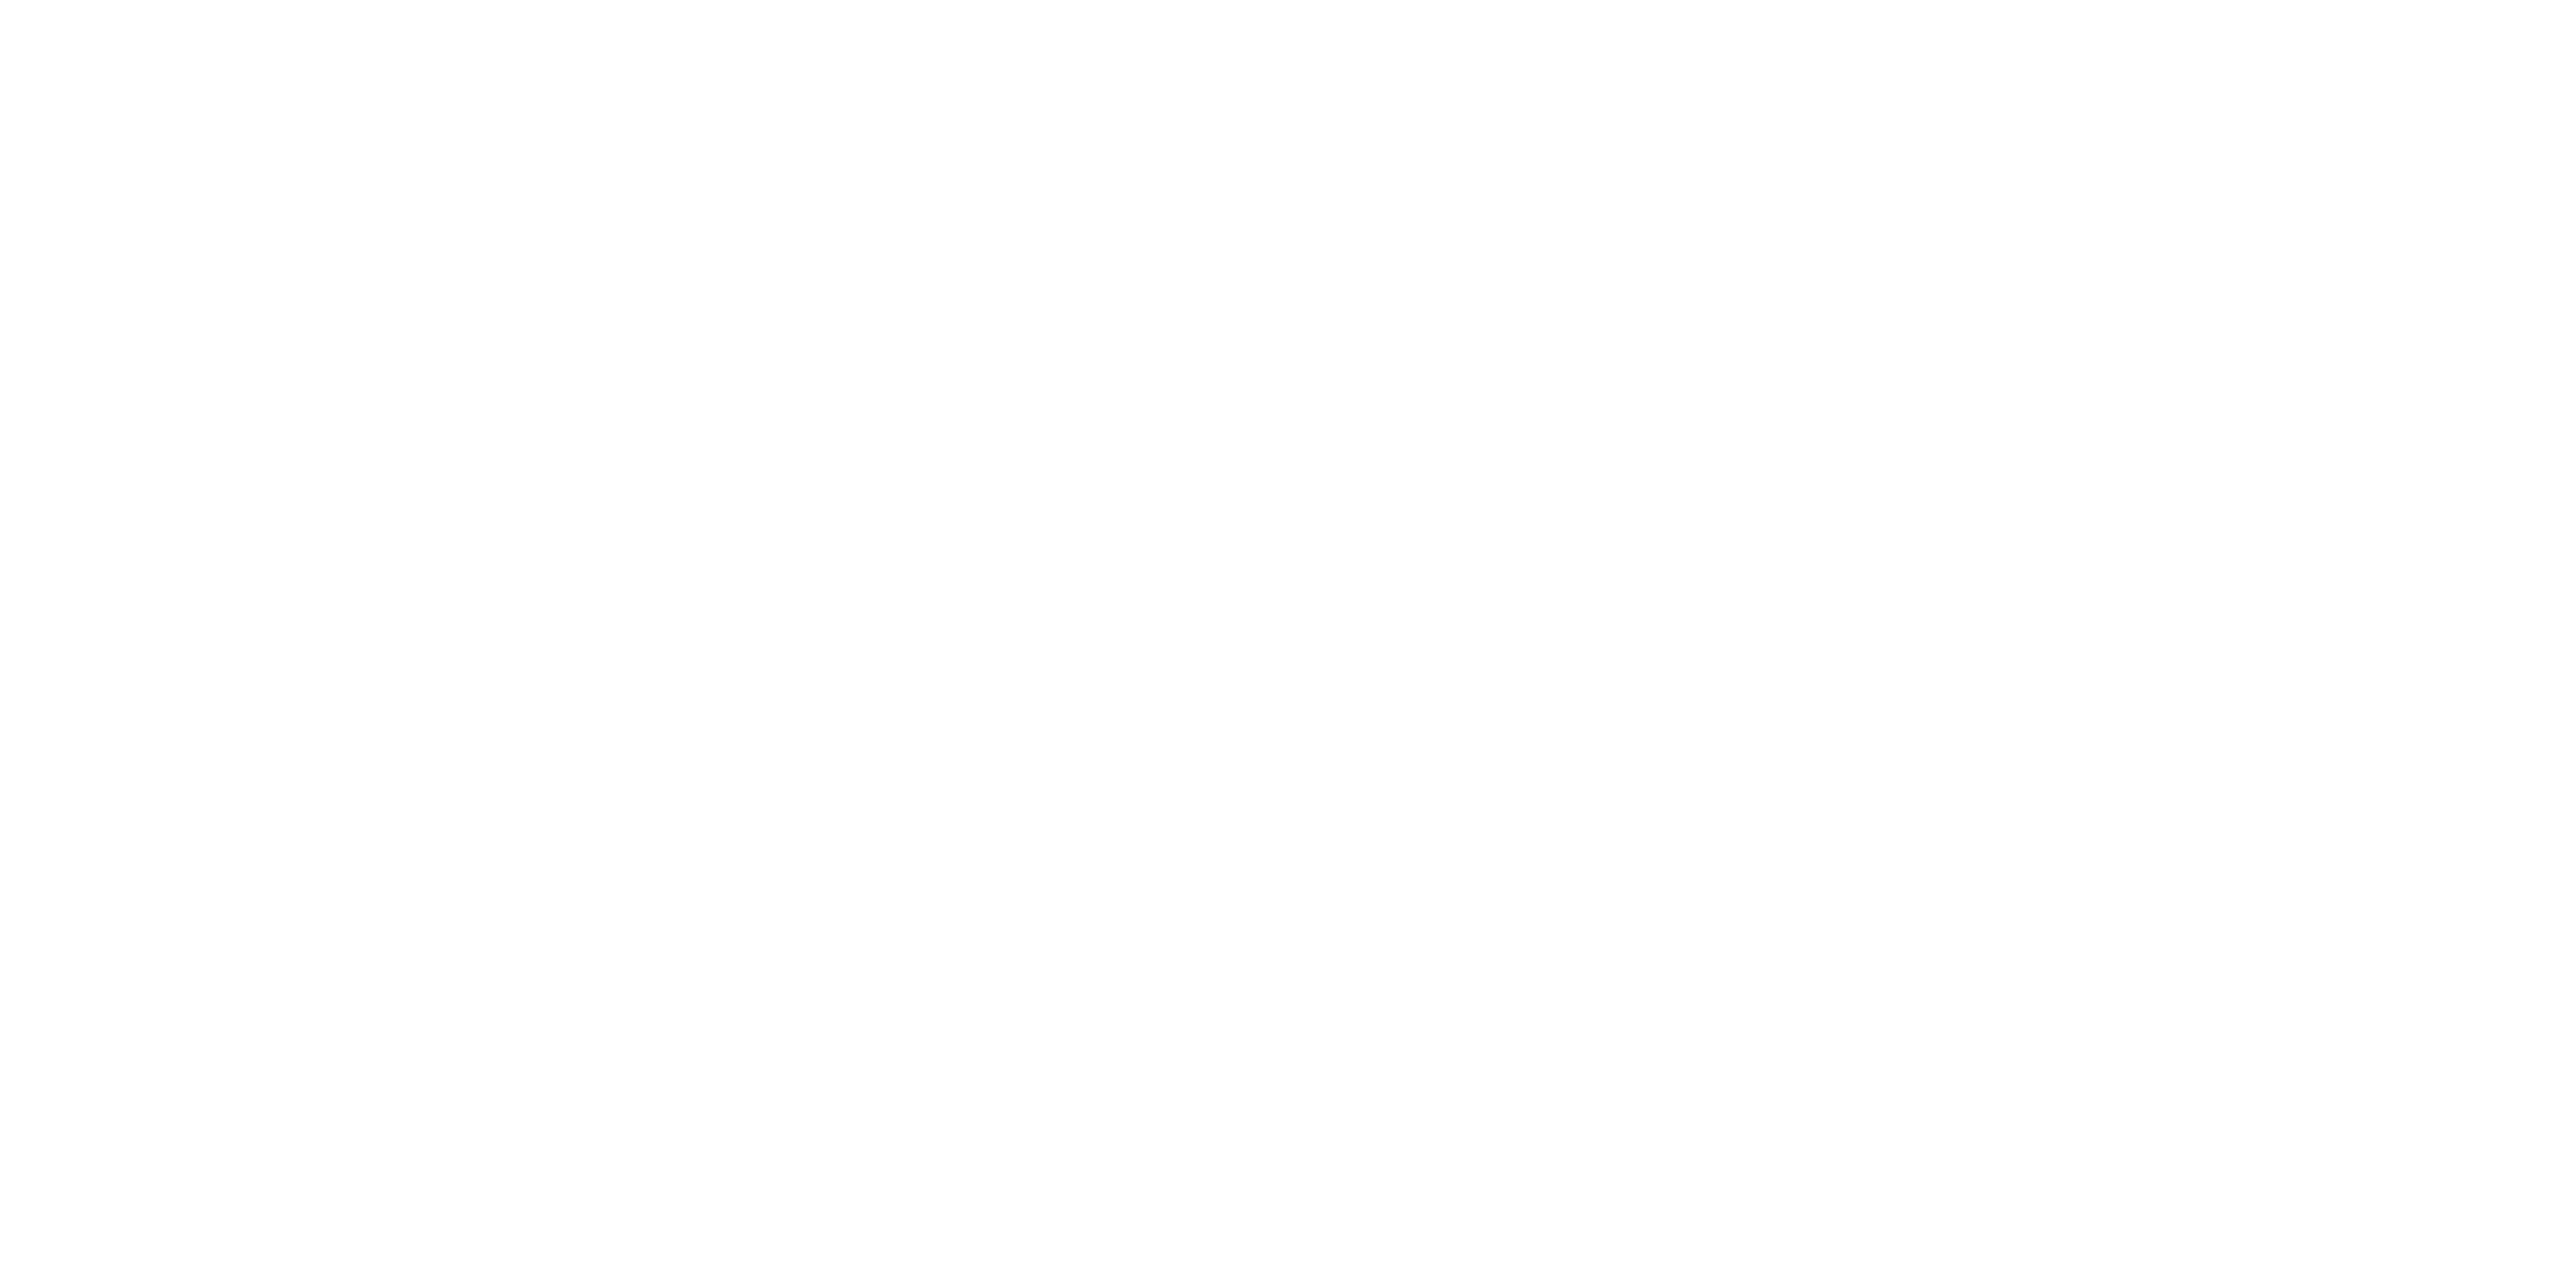

Iteration   50 objective val 6.819e+07 solution NRMSE 1.689e+00 l2 distance to solution 2.740e+02


<IPython.core.display.Javascript object>


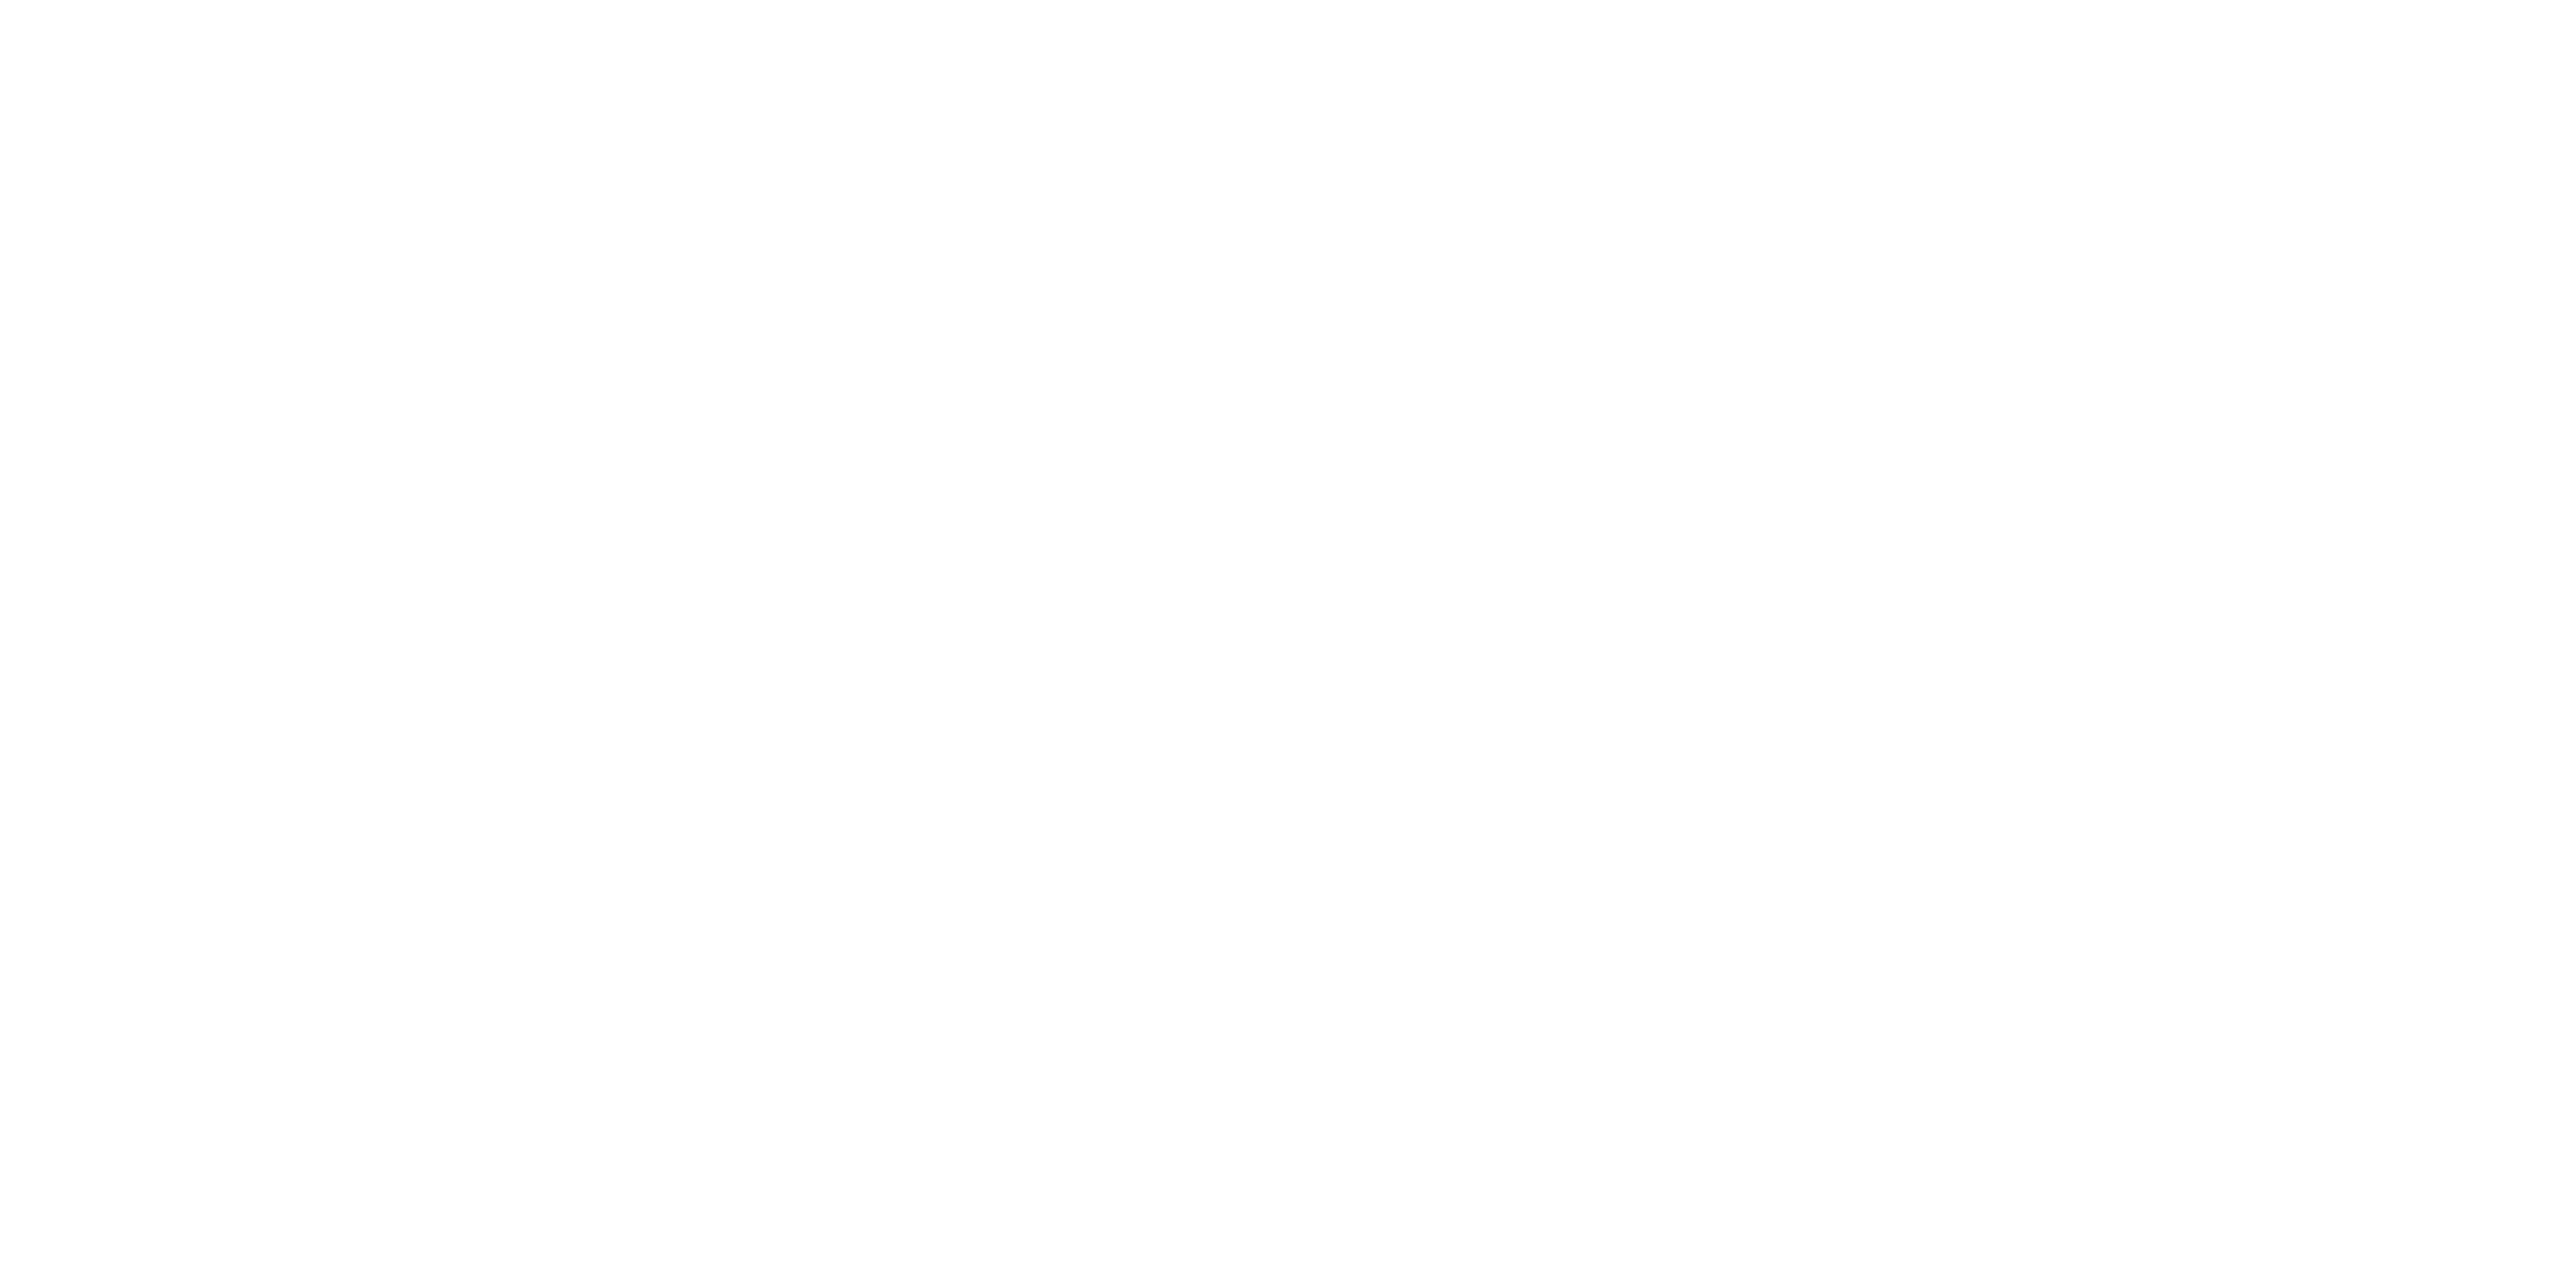

Iteration  100 objective val 6.817e+07 solution NRMSE 1.689e+00 l2 distance to solution 2.739e+02


<IPython.core.display.Javascript object>


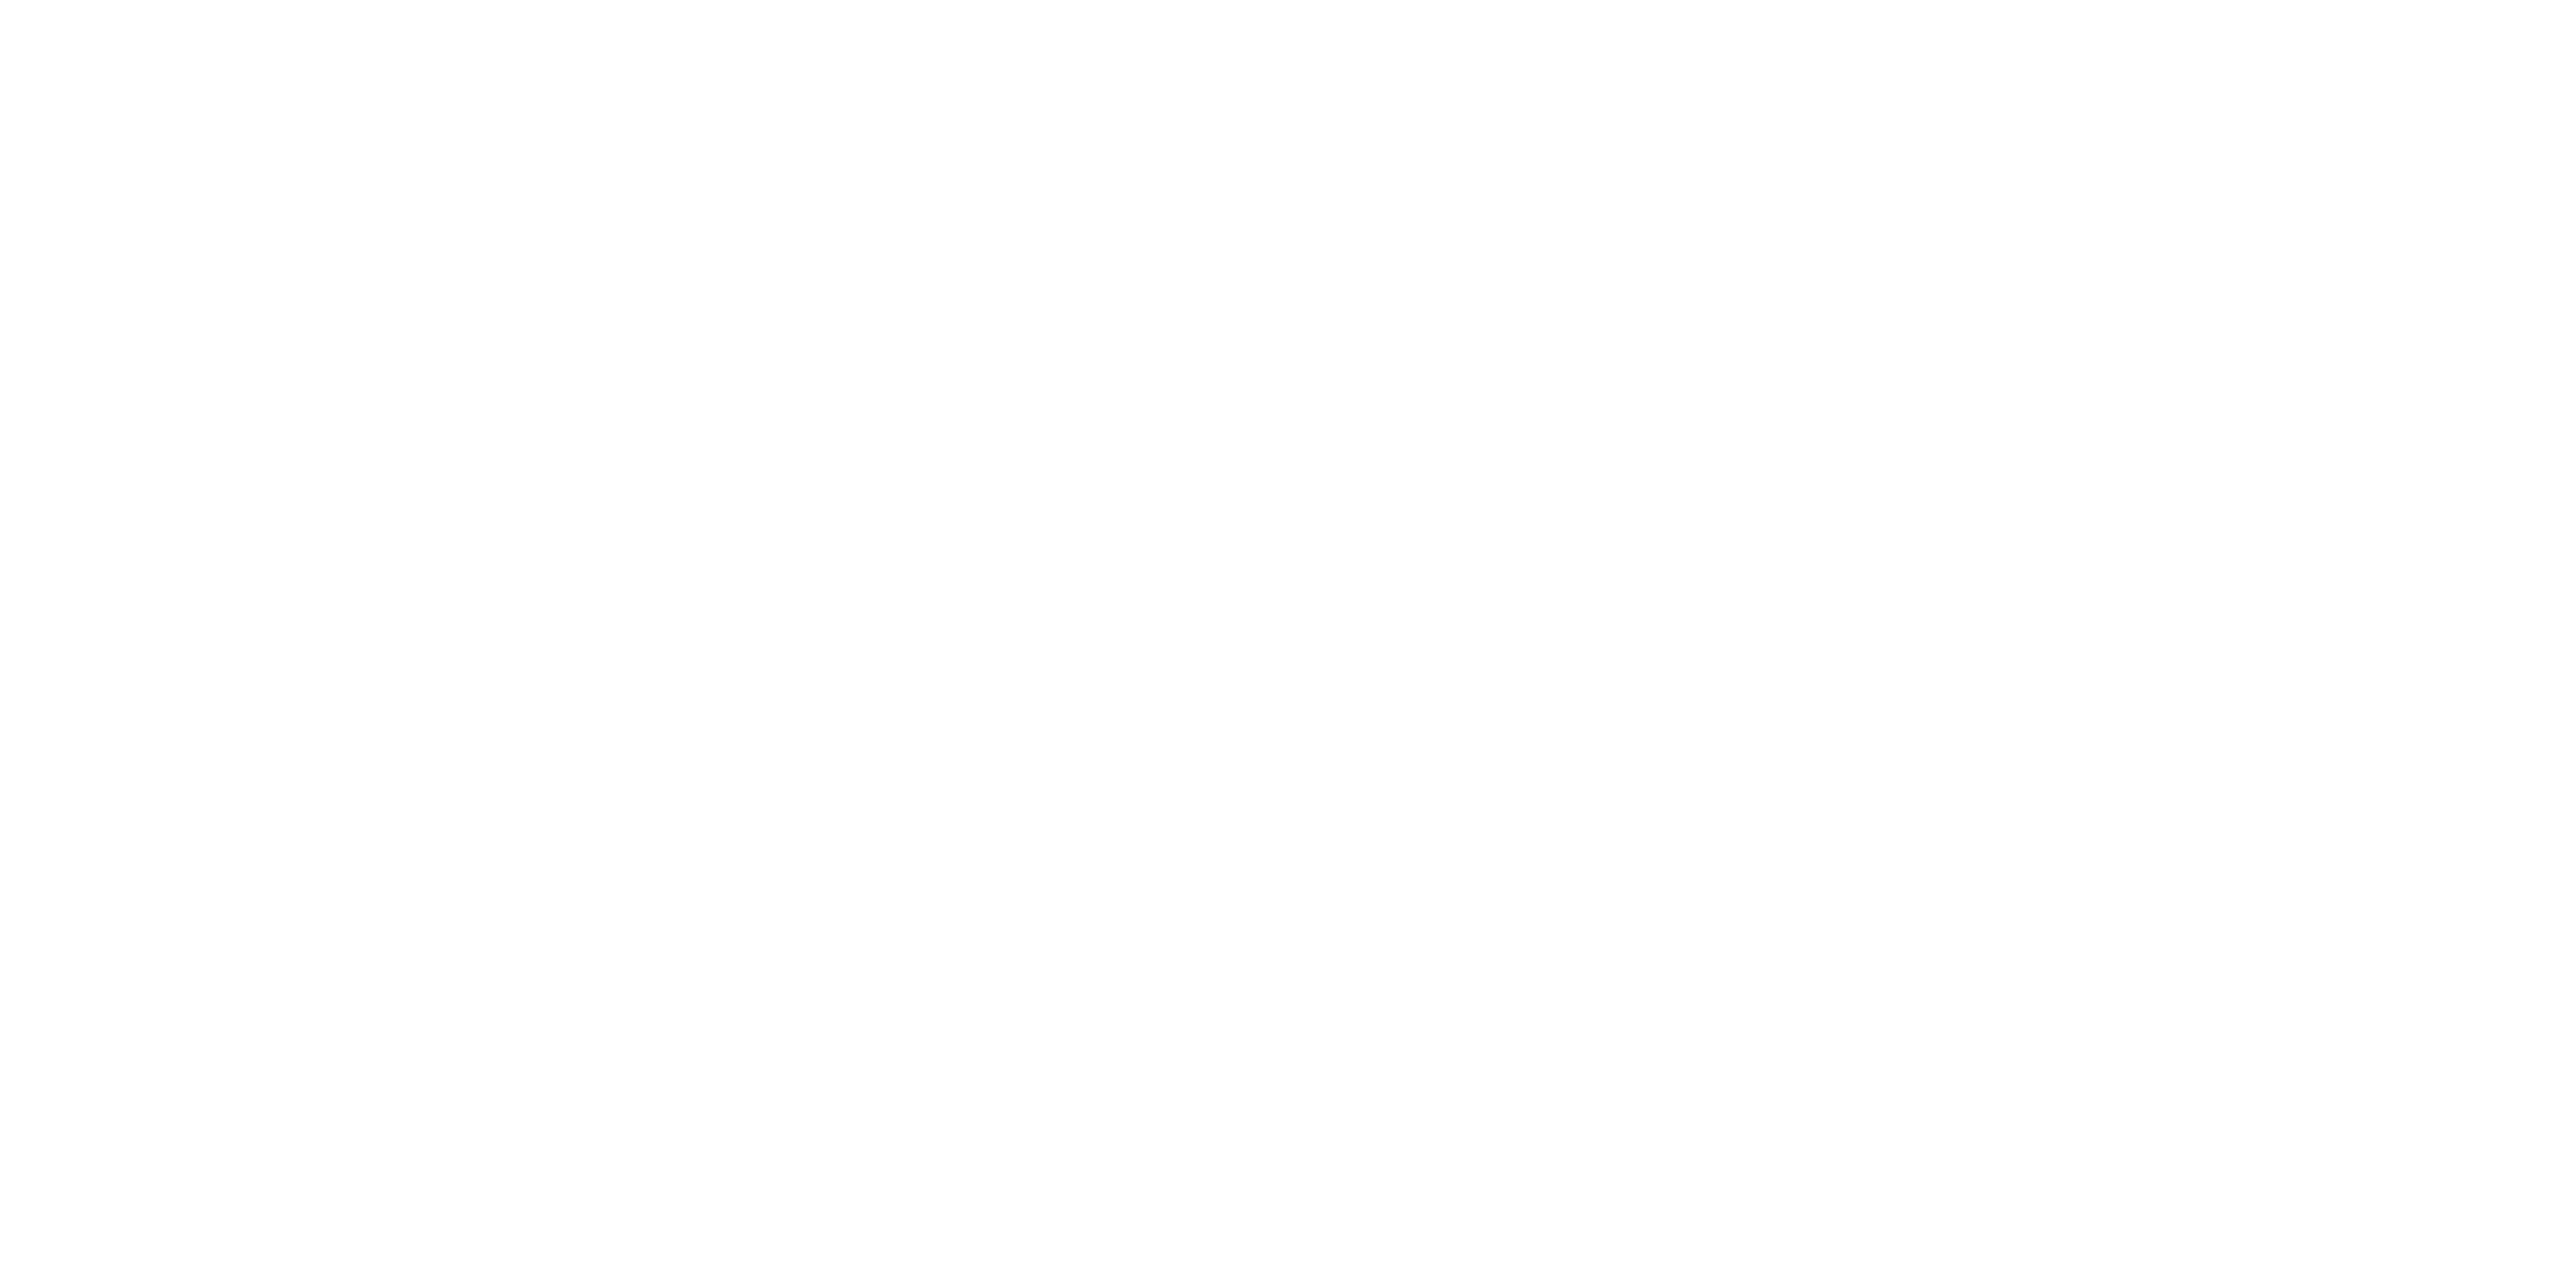

Iteration  150 objective val 6.814e+07 solution NRMSE 1.689e+00 l2 distance to solution 2.735e+02


<IPython.core.display.Javascript object>


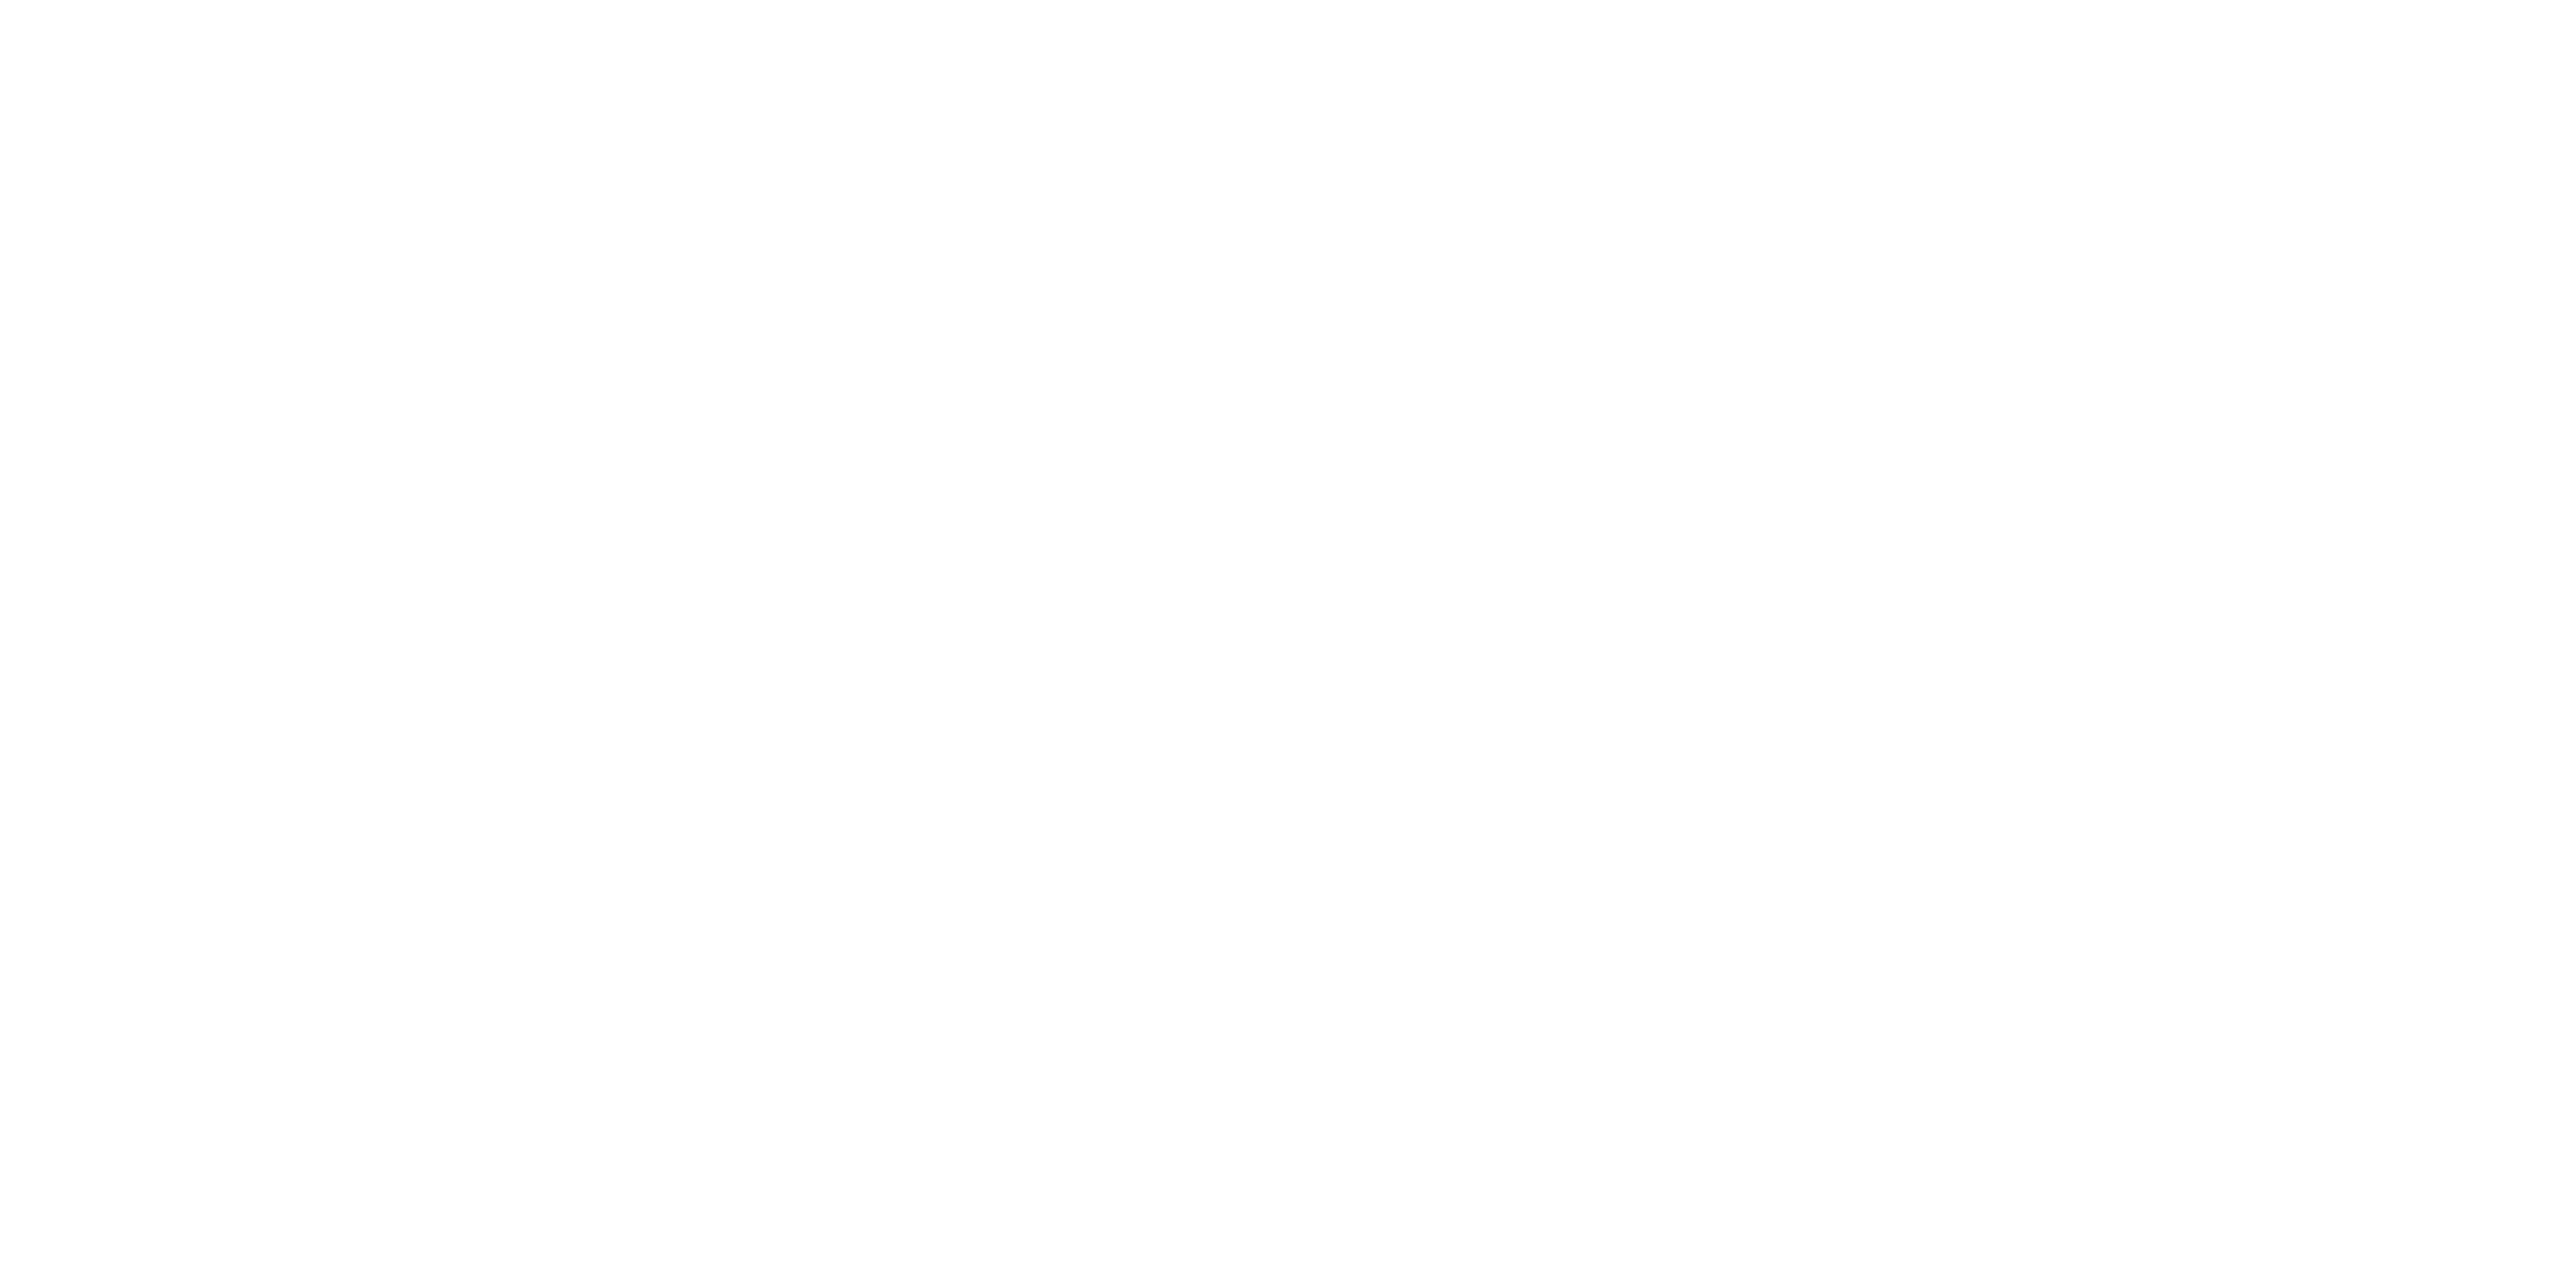

Iteration  200 objective val 6.811e+07 solution NRMSE 1.688e+00 l2 distance to solution 2.734e+02


<IPython.core.display.Javascript object>


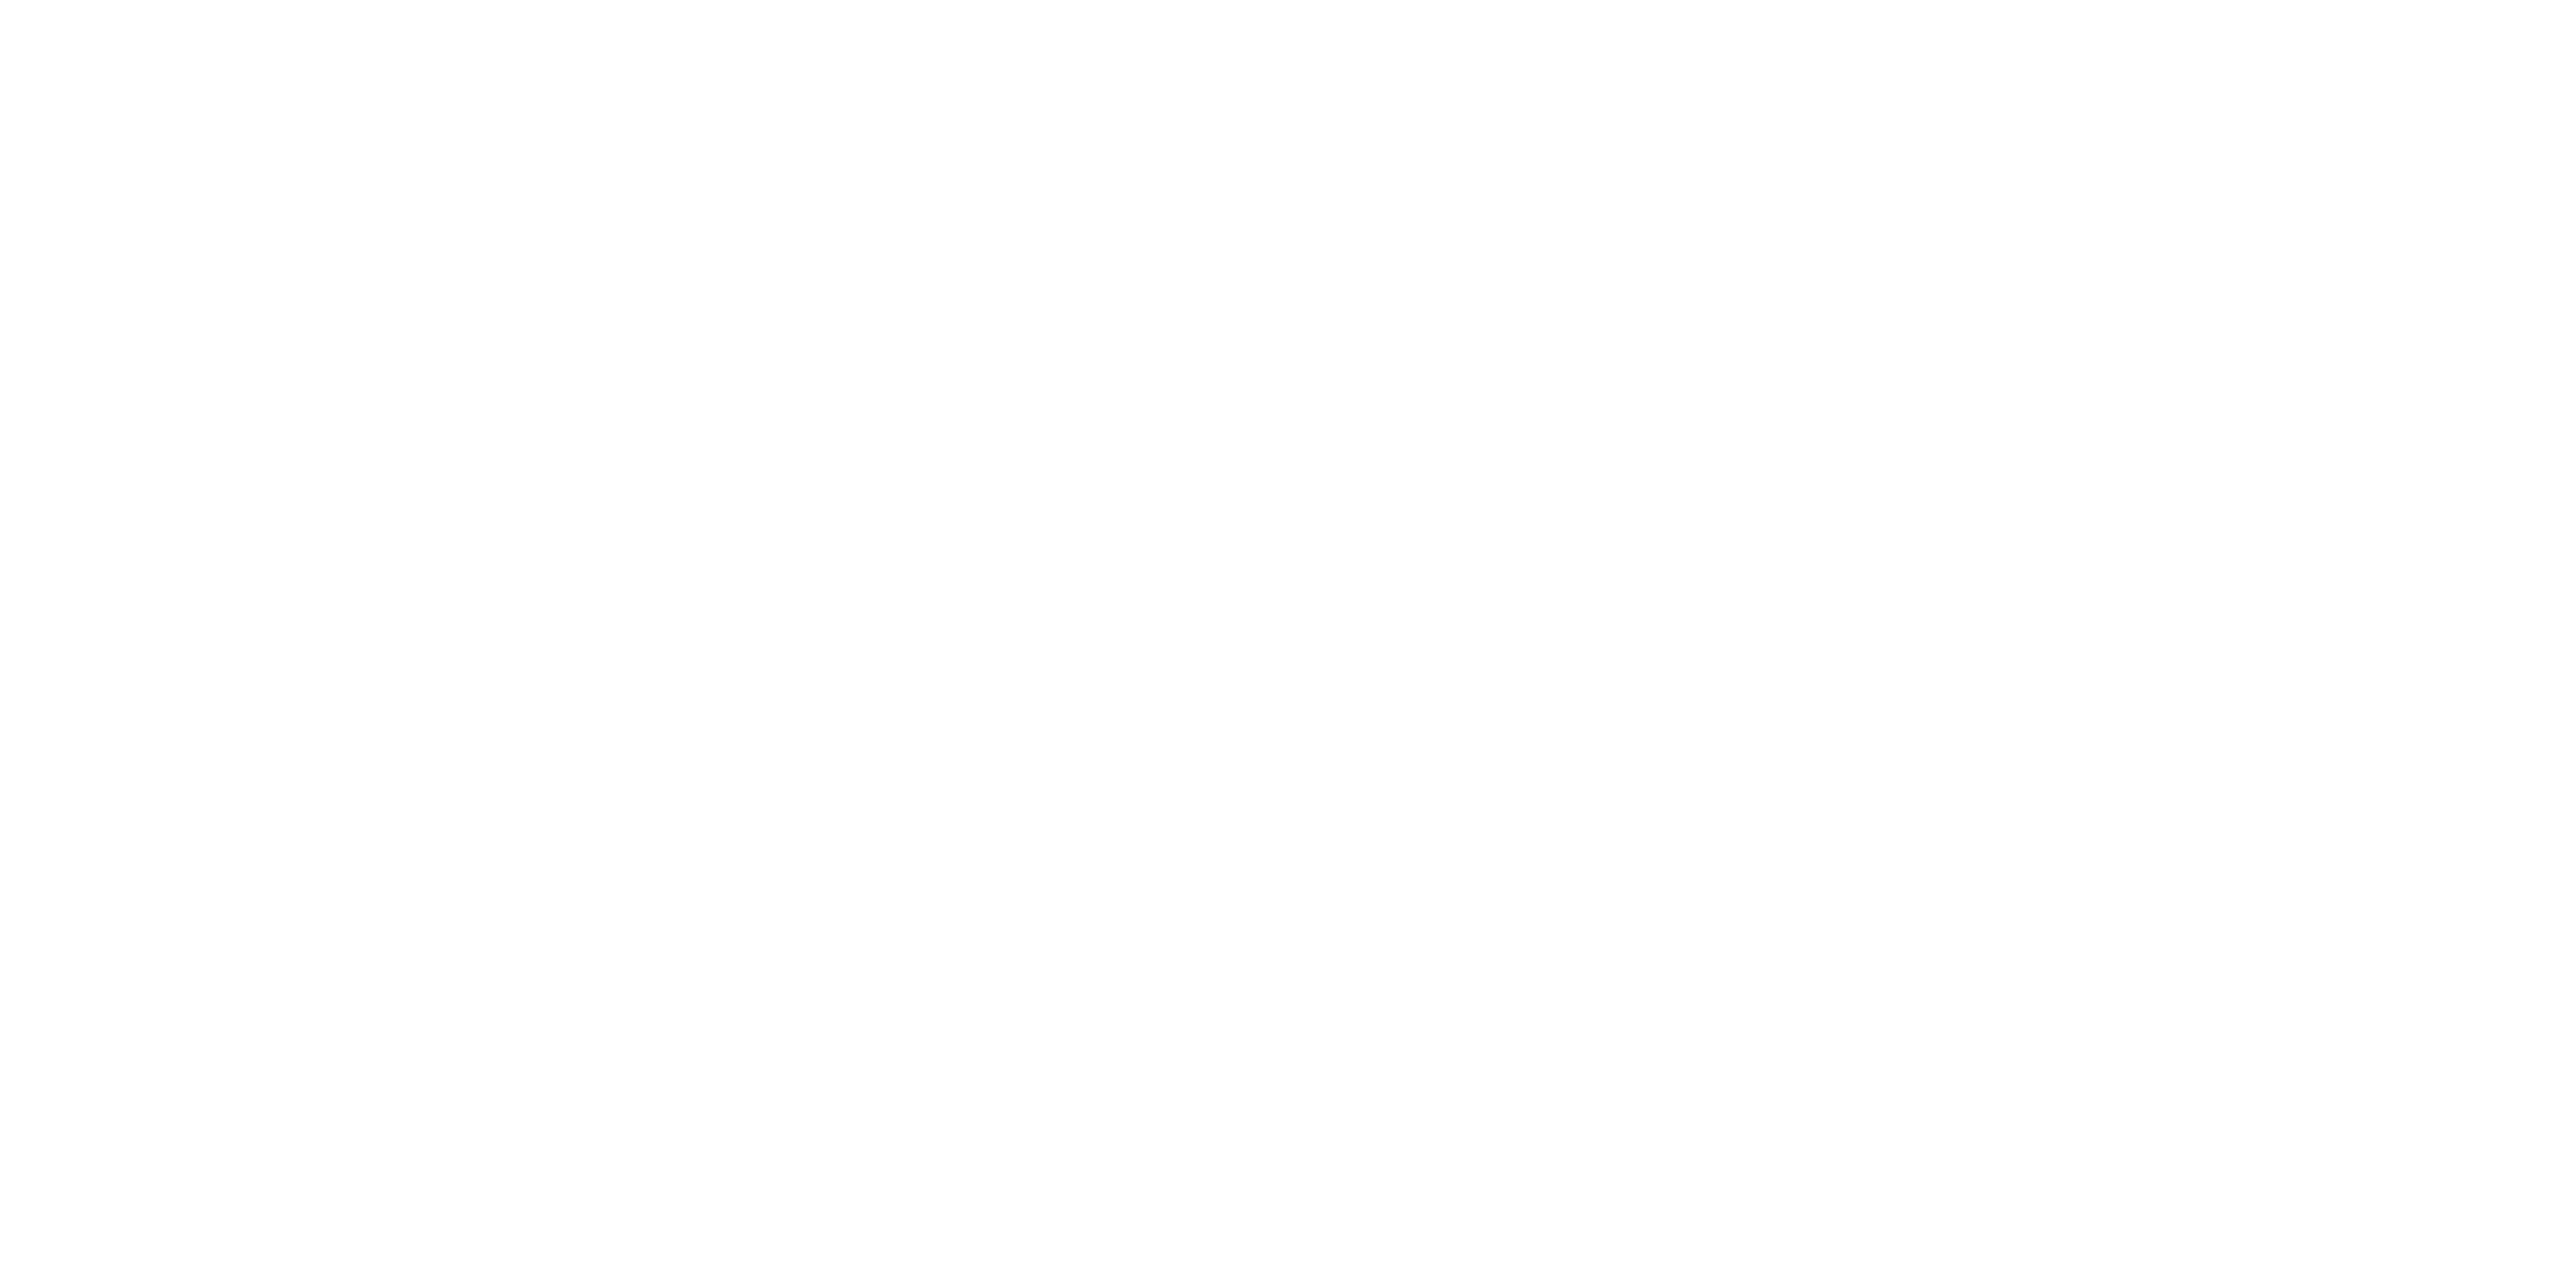

Iteration  250 objective val 6.808e+07 solution NRMSE 1.688e+00 l2 distance to solution 2.731e+02


KeyboardInterrupt: 

In [27]:
lrn.fit(theta0=best_pos)

## Loss surface

In [13]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
scale = np.array([10., 0.01, 1., 10., 10.,
                  10., 1., 10., 10., 10., 0.1,
                  0.1, 0.1, 1., 1., 0.001, 1000])
theta_true_scaled = theta_true / scale

In [14]:
x = np.empty((17, 10))
for i, xx in enumerate(theta_true_scaled):
    x[i] = np.linspace(xx - 1, xx + 1, 10)

In [15]:
thetas = x.T

In [16]:
df = pd.read_csv('./exportedVariables.csv')
df = df.drop_duplicates('time')
df = df.drop(['time'], axis=1)
df.columns = ['p', 'q', 'v', 'phi']
df.phi = df.phi * np.pi / 180

In [17]:
from tqdm import tqdm_notebook

In [18]:
xs = []
vs = []
cs = []

for theta in tqdm_notebook(thetas):
    x, v, c = solve_for_theta(df[['p', 'q']].values, theta * scale, tau=0.0001, tol=1e-3)
    xs.append(x)
    vs.append(v)
    cs.append(c)
    
xs = np.stack(xs)
vs = np.stack(vs)
cs = np.stack(cs)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
vvals = np.zeros((10, 50001, 2))
for i, theta in enumerate(thetas):
    for t, (v, x) in enumerate(zip(vs[i], xs[i])):
        vd, vq = v[0], v[1]
        delta = x[0]
        vvals[i, t, 0] = vd * np.sin(delta) + vq * np.cos(delta)
        vvals[i, t, 1] = - vd * np.cos(delta) + vq * np.sin(delta)

In [20]:
vrefs = df[['v', 'phi']].values
vrefs.shape

(50001, 2)

In [21]:
vrefs2 = np.zeros((1, 50001, 2))
for t, v in enumerate(vrefs):
    vt = v[0]
    anglev = v[1]
    v = vt * np.exp(1j * anglev)
    vrefs2[0, t, 0] = v.real
    vrefs2[0, t, 1] = v.imag

In [22]:
vrefs2 = np.tile(vrefs2, (10, 1, 1))

In [23]:
objectives = np.mean(np.linalg.norm(vvals-vrefs2, ord=2, axis=2) ** 2, axis=1)

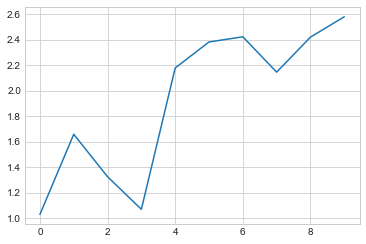

In [24]:
plt.plot(objectives)

In [25]:
def objective(theta, inj, ref, tol=1e-16):
    x, v, c = solve_for_theta(inj, theta * scale, tau=0.0001, tol=tol)
    vr = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vi = np.array([- vv[0] * np.cos(xx[0]) + vv[1] * np.sin(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vvals = np.vstack([vr, vi]).T
    vrefs = np.zeros((len(ref), 2))
    for t, v in enumerate(ref):
        vt = v[0]
        anglev = v[1]
        v = vt * np.exp(1j * anglev)
        vrefs[t, 0] = v.real
        vrefs[t, 1] = v.imag
    return vvals, vrefs, np.mean(np.linalg.norm(vvals-vrefs, ord=2, axis=1) ** 2, axis=0)

In [21]:
vvals, vrefs, v = objective(theta_true_scaled, df[['p', 'q']].values, df[['v', 'phi']].values)

In [22]:
v

2.3024444147492176e-10

In [133]:
np.mean(np.linalg.norm(vvals-vrefs, axis=1) ** 2)

3.969505239834243e-06

In [131]:
vrefs

array([[0.88012213, 0.47474733],
       [0.88012213, 0.47474733],
       [0.88012213, 0.47474733],
       ...,
       [0.88011743, 0.47473289],
       [0.88011743, 0.47473289],
       [0.88011743, 0.47473289]])

126 pairs x 100 evaluations x 1 minute = 210 hours = 8.75 days

In [66]:
from tqdm import tnrange

In [134]:
values = np.zeros((17, 100))
for i in tnrange(17):
    xrange = np.linspace(theta_true_scaled[i]-1, theta_true_scaled[i]+1, 100)
    for j, x in enumerate(xrange):
        theta = theta_true_scaled.copy()
        theta[i] = x
        _, _, values[i, j] = objective(theta, df[['p', 'q']].values, df[['v', 'phi']].values, tol=1e-3)

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packa

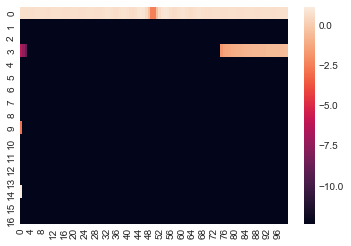

In [136]:
sns.heatmap(np.log(values))

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Text(0.5, 0, 'objective value')

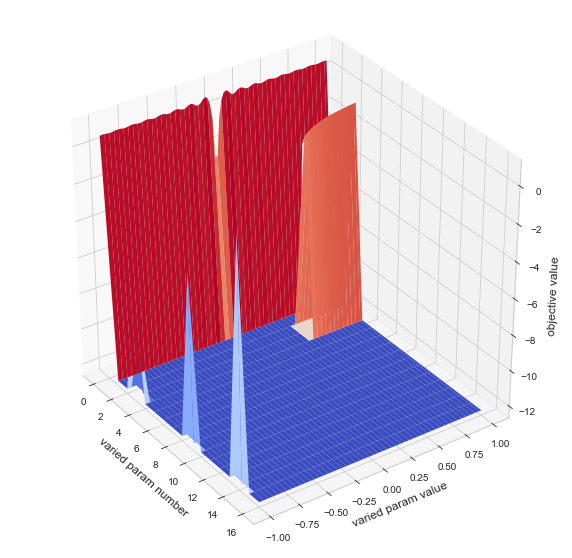

In [138]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(range(17), np.linspace(-1, 1, 100))
ax.plot_surface(xx, yy, np.log(values).T, cmap=cm.coolwarm)
ax.view_init(33, -35)
ax.set_xlabel('varied param number', fontsize=12)
ax.set_ylabel('varied param value', fontsize=12)
ax.set_zlabel('objective value', fontsize=12)

In [26]:
proj = np.random.randn(2, 17)

In [27]:
x = np.linspace(-10, 10)
xx, yy = np.meshgrid(x, x)

In [28]:
values = np.zeros((50, 50))
for i, (x, y) in enumerate(zip(tqdm_notebook(xx), yy)):
    thetas = np.stack([x, y]).T @ proj
    for j, theta in enumerate(thetas):
        _, _, values[i, j] = objective(theta, df[['p', 'q']].values, df[['v', 'phi']].values, tol=1e-3)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in add
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow enco

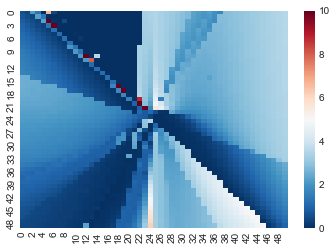

In [38]:
sns.heatmap(np.log(values), vmin=np.min(np.log(values)), vmax=10, cmap='RdBu_r')

In [36]:
np.max(np.log(values))

52.647567112604634

In [47]:
%matplotlib inline
plt.ioff()

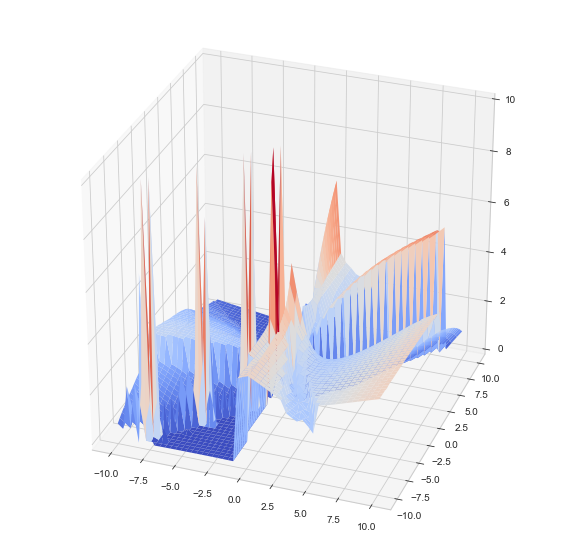

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
ax.plot_surface(xx, yy, np.clip(np.log(values), -1.5, 10), cmap=cm.coolwarm)
ax.view_init(30, -70)

In [150]:
proj2 = np.random.randn(2, 17)

In [151]:
values2 = np.zeros((50, 50))
for i, (x, y) in enumerate(zip(tqdm_notebook(xx), yy)):
    thetas = np.stack([x, y]).T @ proj2
    for j, theta in enumerate(thetas):
        _, _, values2[i, j] = objective(theta, df[['p', 'q']].values, df[['v', 'phi']].values, tol=1e-3)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

KeyboardInterrupt: 